In [2]:
from stable_baselines3 import PPO
from train import Train
from cyclesgym.utils import _evaluate_policy
from cyclesgym.paths import PROJECT_PATH
from cyclesgym.plot_utils import set_size, NEURIPS_TEXT_WIDTH, NEURIPS_FONT_FAMILY, set_up_plt
import numpy as np
import matplotlib.pyplot as plt
import wandb
from matplotlib.cm import get_cmap

In [3]:
color = get_cmap('Accent').colors
set_up_plt(NEURIPS_FONT_FAMILY)

In [4]:
config = dict(train_start_year=1980, train_end_year=1998, eval_start_year=1998, eval_end_year=2016,
              total_timesteps=1000000, eval_freq=1000, n_steps=80, batch_size=64, n_epochs=10, run_id=0,
              norm_reward=True, method="PPO", verbose=1, n_process=8, device='auto')
api = wandb.Api()

runs = api.runs("koralabs/experiments_crop_planning")
selected_runs = ['1hxh40tm', '1p4iajyk']

actions = []
rewards = []
titles = []
for run in runs:
    dir = [dir for dir in PROJECT_PATH.joinpath('wandb').iterdir() if run.path[-1] in str(dir)]
    if len(dir) > 0 and run.path[-1] in selected_runs:
        dir = dir[0]
        file = dir.joinpath('files/models/eval_det/best_model')
        run_config = run.config
        eval_env_class = 'CropPlanningFixedPlanting'
        if run_config.get('non_adaptive', False) == 'True':
            eval_env_class = 'CropPlanningFixedPlantingRotationObserver'
        config['eval_env_class'] = eval_env_class
        
        envs = Train(config).create_envs()

        model = PPO.load(file, device='cpu')

        env = envs[1]
        
        if 'Rotation' in eval_env_class:
            title = r'\textsc{nonadaptive}'
        else:
            title = r'SoilN observations'
            
        mean_reward, std_reward, episode_actions, episode_rewards, episode_probs, episode_action_rewards = \
            _evaluate_policy(model, env,  n_eval_episodes=1, deterministic=True)
        
        actions.append(episode_actions)
        rewards.append(episode_action_rewards)
        titles.append(title)


Simulation 2022_06_14_10_51_56-673fa8e1-7378-49a2-b558-4b2abd40fb77/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_51_56-75a65c38-2510-487c-a892-df6b257b735f/control running ...

Simulation time: 1 seconds.

Simulation 2022_06_14_10_51_57-57037f67-45b8-4540-b02d-3dfe071f4b17/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_51_57-46465b35-1fe2-4918-a4d7-984151490122/control running ...

Simulation time: 1 seconds.

Simulation 2022_06_14_10_51_58-937ba563-014a-4444-8582-14d08841d667/control running ...

Simulation time: 0 seconds.


performed because operation year is larger than years in rotation. Please check
Line 255 in 2022_06_14_10_51_58-937ba563-014a-4444-8582-14d08841d667/operation.operation.



Simulation 2022_06_14_10_52_07-f7cbdd4e-3893-48b8-98cd-f0e413401ffe/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_52_07-8f8f4ccd-2ac3-4935-8b11-2090d869cf55/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_52_07-111161cc-7ec7-44ce-b36a-d5ce0e63ce2d/control running ...

Simulation time: 1 seconds.

Simulation 2022_06_14_10_52_08-566d9409-6efc-4c9f-8ae4-900e774d2ace/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_52_08-e14b0390-7421-4760-a070-d9a5c793bfd7/control running ...

Simulation time: 0 seconds.

Simulation 2022_06_14_10_52_09-fce0567d-037d-4291-974a-2ee4e14afa0f/control running ...

Simulation time: 0 seconds.


performed because operation year is larger than years in rotation. Please check
Line 255 in 2022_06_14_10_52_09-fce0567d-037d-4291-974a-2ee4e14afa0f/operation.operation.



Simulation 2022_06_14_10_52_18-e6e81237-59c8-471e-8ecd-37188bb5ee67/control running ...

Simulation time: 0 seconds.


In [9]:
def plot_two_policies(actions, rewards, titles, figsize): 
    fig, ax = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey='row')
    x = 1980 + np.arange(19)
    for i, (episode_actions, episode_rewards, title) in enumerate(zip(actions, rewards, titles)):
        episode_actions = episode_actions.squeeze()
        planting_date = episode_actions[:, 1]
        planting_date = 90 + planting_date * 7
        crop = episode_actions[:, 0]

        ax[0,i].bar(x, np.array(episode_rewards)/1000., color=[color[c] for c in crop])
        ax[0,i].set_title(title)
        ax[1,i].scatter(x, planting_date, color=[color[c] for c in crop], s=100, marker='o')
        ax[1,i].set_xticks(x)
        ax[1,i].set_xticklabels(x, rotation=40)
        ax[1,i].set_xlim(min(x) - 0.8, max(x) + 0.8)
    
    ax[1,0].set_ylabel(r'Planting date [DOY]')
    ax[0,0].set_ylabel(r'Year reward [k\$]')
    ax[1,1].set_xlabel(r'Years')
    ax[1,1].xaxis.set_label_coords(-0.3, -0.3)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.legend()
    plt.savefig(PROJECT_PATH.joinpath('figures/crop_planning_policies/crop_planning_policies.pdf'), 
                bbox_inches='tight')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


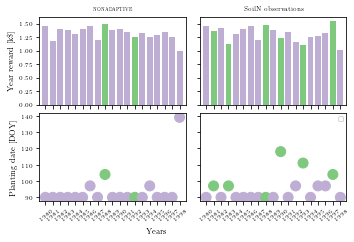

In [10]:
plot_two_policies(actions, rewards, titles, set_size(NEURIPS_TEXT_WIDTH, fraction=1, subplots=(2, 2)))